In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pmdarima import auto_arima


import warnings
warnings.filterwarnings('ignore')

In [2]:
file_to_load = "data/us_treasury_yields_daily.csv"
original_data = pd.read_csv(file_to_load)

raw_data = original_data.copy()
# convert date to datetime format
raw_data['date'] = pd.to_datetime(raw_data['date'])

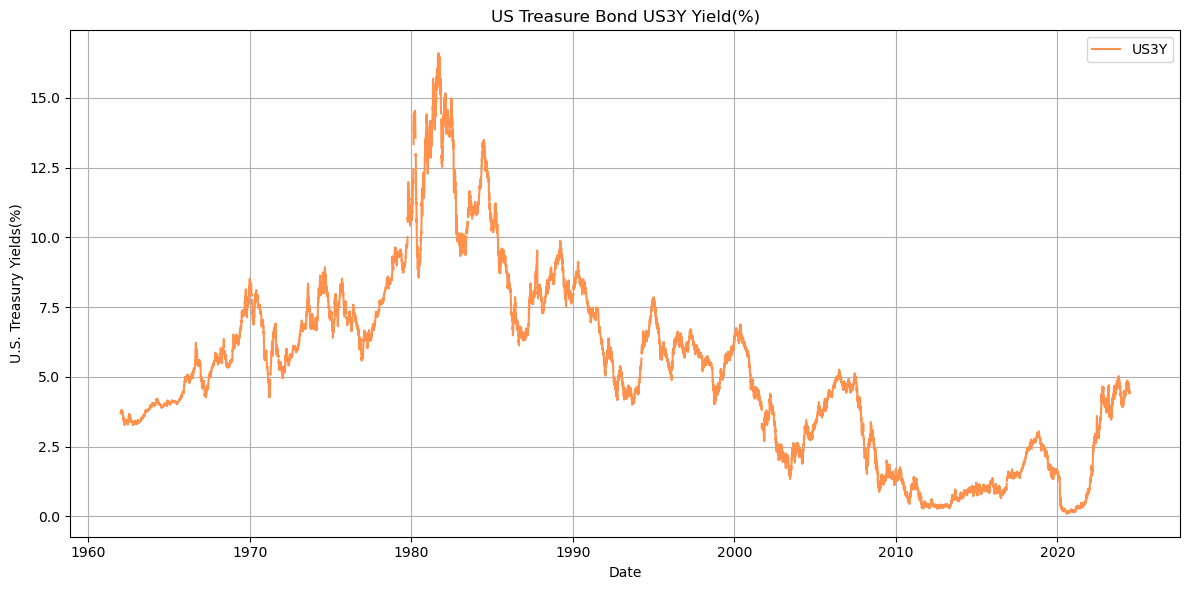

In [3]:
plt.figure(figsize=(12,6))
plt.plot(raw_data.date, raw_data.US3Y, label = 'US3Y', color = '#FF914D')
plt.title('US Treasure Bond US3Y Yield(%)')
plt.xlabel('Date')
plt.ylabel('U.S. Treasury Yields(%)')
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()

# Data Preprocessing

## Data Cleaning

In [4]:
# convert date column to index
data = raw_data.set_index('date').asfreq('d')

## Handling Missing Values

### Filling Missing Values Best Practice for Stock Data
1 Fill missing values before differencing, unless missingness is small and caused by differencing itself.
2 For non-trading days (weekends/holidays), decide whether to:
Forward fill (common for stock closing prices), or
Remove them entirely (if modeling only trading days).

In [5]:
data['US3Y'] = data['US3Y'].fillna(method='ffill')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22817 entries, 1962-01-02 to 2024-06-21
Freq: D
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   US1M    5726 non-null   float64
 1   US3M    10702 non-null  float64
 2   US6M    10702 non-null  float64
 3   US1Y    15604 non-null  float64
 4   US2Y    12012 non-null  float64
 5   US3Y    22817 non-null  float64
 6   US5Y    15604 non-null  float64
 7   US7Y    13734 non-null  float64
 8   US10Y   15604 non-null  float64
 9   US20Y   13915 non-null  float64
 10  US30Y   11834 non-null  float64
dtypes: float64(11)
memory usage: 2.1 MB


### Select data date range

In [6]:
filtered_data = data.loc['2000-01-01':]
# filtered_data = data
filtered_data.head()

,US1M,US3M,US6M,US1Y,US2Y,US3Y,US5Y,US7Y,US10Y,US20Y,US30Y
date,,,,,,,,,,,
2000-01-01,NaN,NaN,NaN,NaN,NaN,6.29,NaN,NaN,NaN,NaN,NaN
2000-01-02,NaN,NaN,NaN,NaN,NaN,6.29,NaN,NaN,NaN,NaN,NaN
2000-01-03,NaN,5.48,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6.61
2000-01-04,NaN,5.43,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6.53
2000-01-05,NaN,5.44,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6.64


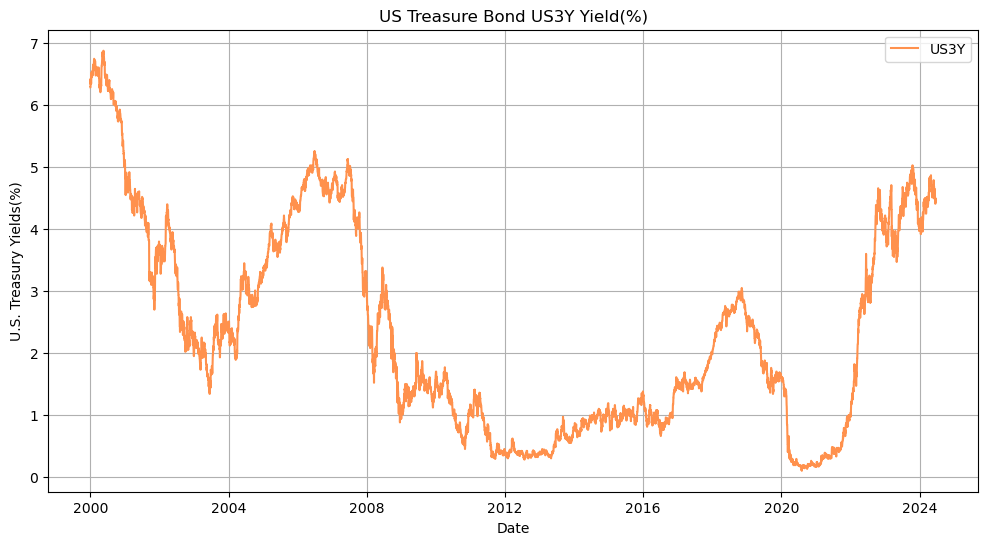

In [7]:
plt.figure(figsize=(12,6))
plt.plot(filtered_data.index, filtered_data.US3Y, label = 'US3Y', color = '#FF914D')
plt.title('US Treasure Bond US3Y Yield(%)')
plt.xlabel('Date')
plt.ylabel('U.S. Treasury Yields(%)')
plt.legend()
plt.grid(True)
plt.show()

## STL Decomposition

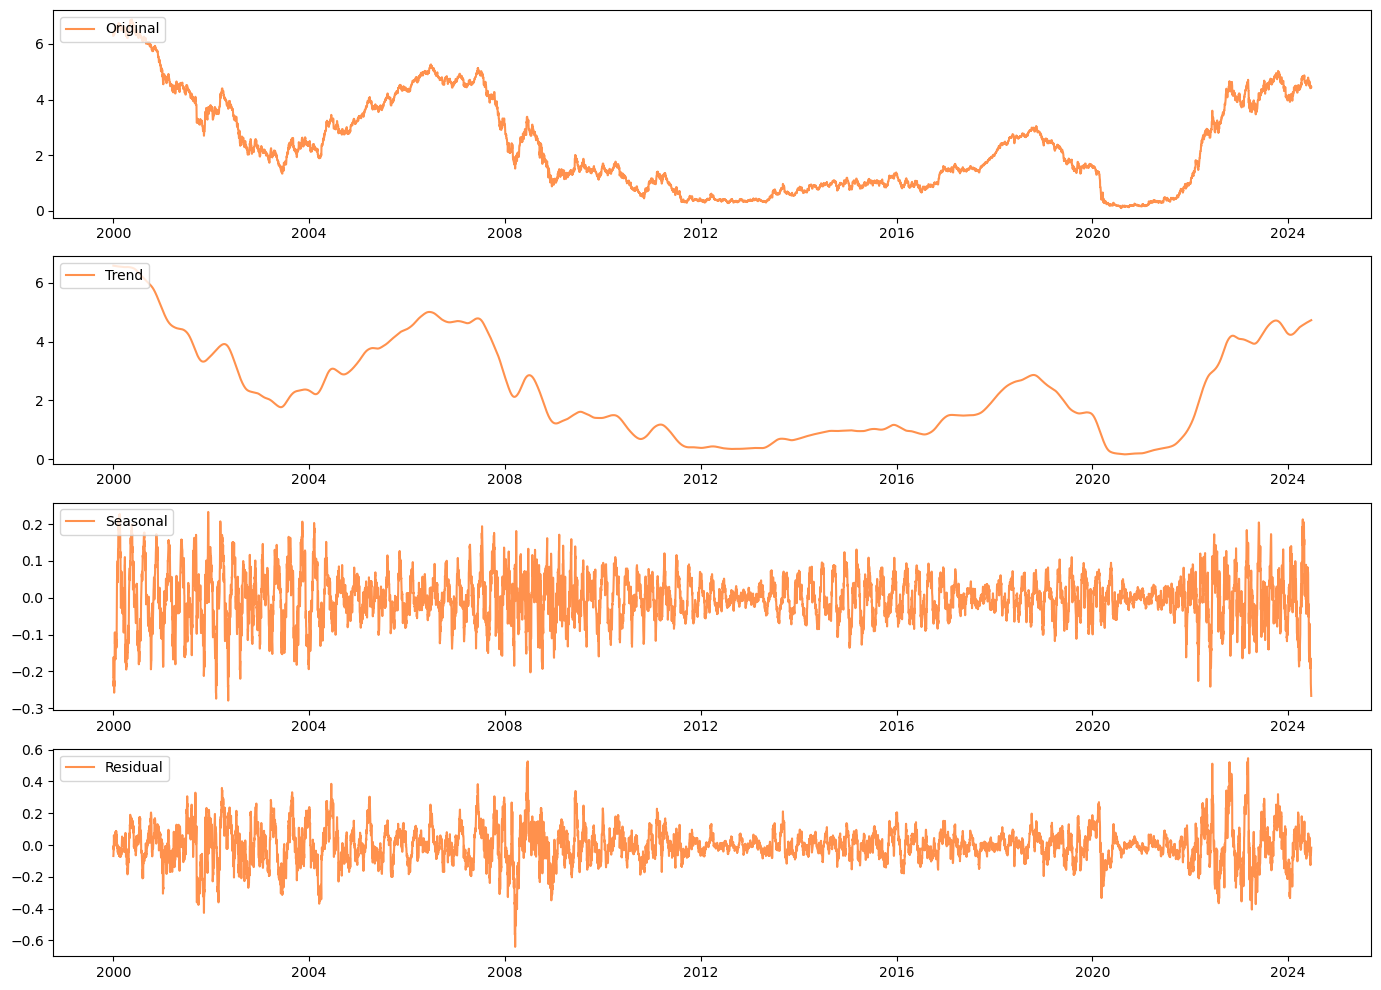

In [8]:
from statsmodels.tsa.seasonal import STL

# perform STL decomposition
stl = STL(filtered_data.US3Y, period=90)
result = stl.fit()

# plot the decomposition components
plt.figure(figsize = (14,10))
plt.subplot(411)
plt.plot(result.observed, label = 'Original', color = '#FF914D')
plt.legend(loc = 'upper left')

plt.subplot(412)
plt.plot(result.trend, label = 'Trend', color = '#FF914D')
plt.legend(loc = 'upper left')

plt.subplot(413)
plt.plot(result.seasonal, label = 'Seasonal', color = '#FF914D')
plt.legend(loc = 'upper left')
plt.subplot(414)
plt.plot(result.resid, label = 'Residual', color = '#FF914D')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

# Stationarity Test

In [9]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [10]:
check_stationarity(filtered_data.US3Y)

ADF Statistic: -2.350025
p-value: 0.156341
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Non-stationary


# Making Data Stationary

## Differecing method

In [11]:
# first order difference
rate_diff = filtered_data.US3Y.diff()
check_stationarity(rate_diff.dropna())

ADF Statistic: -15.401199
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


In [12]:
# filtered_data.US3Y.diff()

## Transformation - Logarithmic

In [13]:
#log transformation
rate_log = np.log(filtered_data.US3Y.dropna())
check_stationarity(rate_log)

ADF Statistic: -1.924947
p-value: 0.320418
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Non-stationary


## Transformation - Power

In [14]:
#square root transformation
rate_sqrt = np.sqrt(filtered_data.US3Y.dropna())
check_stationarity(rate_sqrt)

ADF Statistic: -1.894506
p-value: 0.334650
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Non-stationary


### Choosing differencing method

In [15]:
# stationary_data = data.US3Y.diff().dropna().to_frame()
stationary_data = rate_diff.dropna().to_frame()

In [16]:
stationary_data.head()

,US3Y
date,
2000-01-02,0.00
2000-01-03,0.13
2000-01-04,-0.08
2000-01-05,0.09
2000-01-06,-0.04


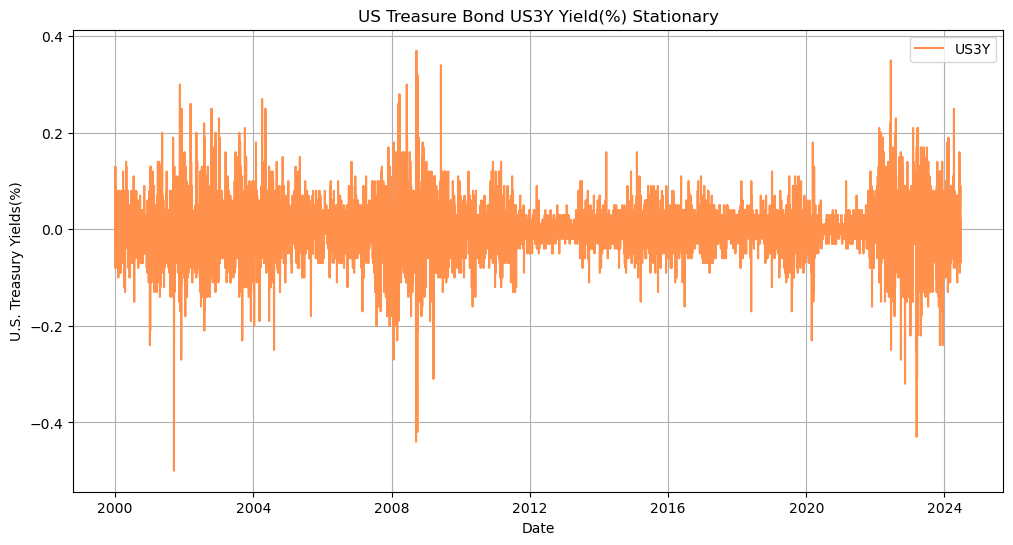

In [17]:
# show stationary data
plt.figure(figsize=(12,6))
plt.plot(stationary_data.index, stationary_data.US3Y, label = 'US3Y', color = '#FF914D')
plt.title('US Treasure Bond US3Y Yield(%) Stationary')
plt.xlabel('Date')
plt.ylabel('U.S. Treasury Yields(%)')
plt.legend()
plt.grid(True)
plt.show()

# Smoothing Data - Not used in Forcasting

In [18]:
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# # using differecing method to sta
# ses_model = ExponentialSmoothing(stationary_data['US3Y']).fit(smoothing_level = 0.7)
# stationary_data['US3Y_SES'] = ses_model.fittedvalues

# # Double Exponential Smoothing (DES) - Holt's Linear trend model
# des_model = ExponentialSmoothing(stationary_data['US3Y'], trend = 'add').fit(smoothing_level = 0.7)
# stationary_data['US3Y_DES'] = des_model.fittedvalues

# # # Triple Exponential Smoothing (TES) - Holt's-Winters method
# tes_model = ExponentialSmoothing(stationary_data['US3Y'], trend = 'add', seasonal = 'add', seasonal_periods = 12).fit(smoothing_level = 0.7)
# stationary_data['US3Y_TES'] = tes_model.fittedvalues


# # Plotting
# plt.figure(figsize = (10, 6))
# plt.plot(stationary_data['US3Y'], label = 'US3Y', color = 'blue', alpha = 0.5)
# plt.plot(stationary_data['US3Y_SES'], label = 'SES (Single Expoential Smoothing)', color = 'green')
# plt.plot(stationary_data['US3Y_DES'], label = 'DES (Double Exponential Smoothing)', color = 'orange')
# plt.plot(stationary_data['US3Y_TES'], label = 'TES (Triple Exponential Smoothing)', color = 'red')

# plt.title('US3Y Stationary with SES, DES, and TES')
# plt.xlabel('Date')
# plt.ylabel('Rate (%)')
# plt.legend()
# plt.grid()
# plt.show()

# ACF and PACF Plot

In [19]:
# take the last 30 days as a test data
train_diff, test_diff = stationary_data['US3Y'][:-30], stationary_data['US3Y'][-30:]

test_previous = filtered_data['US3Y'][-30:]

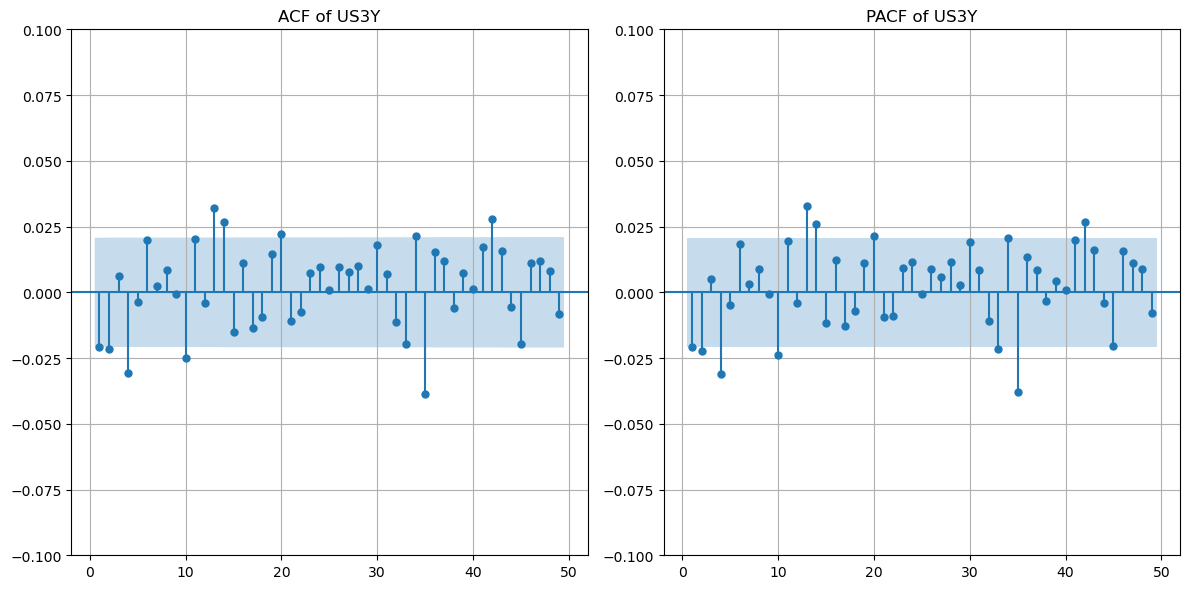

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize = (12, 6))
# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(train_diff, ax=plt.gca(), lags = range(1, 50))
plt.ylim(-0.1, 0.1)
plt.title('ACF of US3Y')
plt.grid(True)
# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(train_diff, ax=plt.gca(), lags = range(1, 50), method = 'ywm')
plt.ylim(-0.1, 0.1)
plt.title('PACF of US3Y')
plt.grid(True)
plt.tight_layout()

plt.show()

# Time Series Forecasting Models

## Use auto_arima

In [21]:
%%time
# Fit Auto ARIMA model
model = auto_arima(
    train_diff,       # target time series
    start_p = 1, 
    max_p = 50, 
    start_q = 1, 
    max_q = 50,
    seasonal=False,      # set True if data is seasonal
    stepwise=True,       # use stepwise search (faster)
    suppress_warnings=True,
    trace=True,           # print model fitting progress
    n_jobs = -1
)
# Summary of the model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22408.091, Time=0.60 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24964.431, Time=0.76 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.99 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22410.091, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-26135.029, Time=1.30 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-26630.020, Time=1.75 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-27031.774, Time=1.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-27367.205, Time=1.03 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-27565.390, Time=1.64 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=-27725.733, Time=2.83 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=-27832.518, Time=3.42 sec
 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=-27885.608, Time=3.72 sec
 ARIMA(10,1,0)(0,0,0)[0] intercept   : AIC=-27996.947, Time=2.31 sec
 ARIMA(11,1,0)(0,0

## AR Model

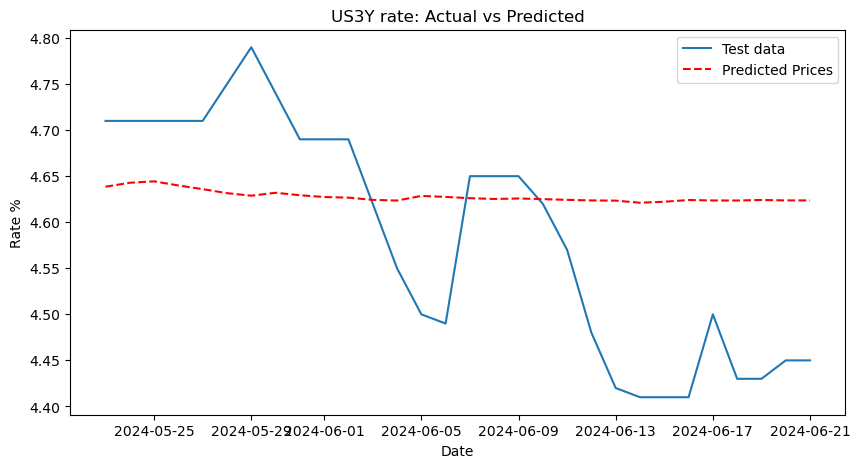

RMSE:  0.12669
Akaike Information Criterion (AIC): -28666.882721385726
Bayesian Information Criterion (BIC) -28425.78510772794
CPU times: total: 1.14 s
Wall time: 180 ms


In [34]:
%%time
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# Fit the Autoregressive model (AR) to the training data
model = AutoReg(train_diff, lags = 32)
model_fit = model.fit()

# Make predictions on the test data
pred_diff = model_fit.predict(
    start = len(train_diff),
    end = len(train_diff) + len(test_diff)-1,
    dynamic=False)

# revert prediction to actual values
test_original = pred_diff.cumsum() + filtered_data['US3Y'][-31]

# Plot the actual vs predicted values
plt.figure(figsize = (10, 5))
plt.plot(test_diff.index, test_previous, label = 'Test data')
plt.plot(test_diff.index, test_original, color = 'red', linestyle = '--', label = 'Predicted Prices')
plt.title('US3Y rate: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Rate %')
plt.legend()
plt.show()

# evaluating model using RMSE score
rmse = round(np.sqrt(mean_squared_error(test_previous, test_original)), 5)
print('RMSE: ', rmse)

# aic and bic
aic = model_fit.aic
bic = model_fit.bic

print(f'Akaike Information Criterion (AIC): {aic}')
print(f'Bayesian Information Criterion (BIC) {bic}')

## MA

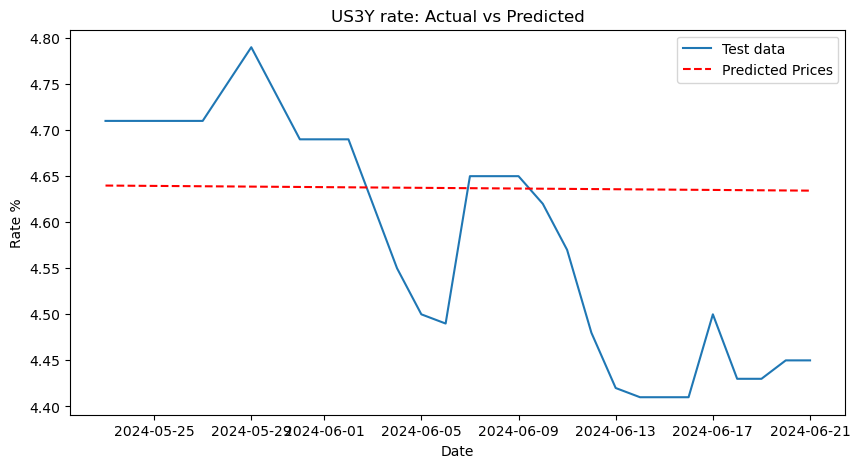

RMSE:  0.13237
CPU times: total: 4.27 s
Wall time: 762 ms


In [36]:
%%time
from statsmodels.tsa.arima.model import ARIMA

# Fit the Moving Average (MA) model to the training data
model = ARIMA(train_diff, order=(0, 0, 0))
model_fit = model.fit()

# Make predictions on the test data
pred_diff = model_fit.predict(
    start = len(train_diff),
    end = len(train_diff) + len(test_diff) - 1,
    dynamic = False)

# revert prediction to actual values
test_original = pred_diff.cumsum() + filtered_data['US3Y'][-31]
# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test_diff.index, test_previous, label='Test data')
plt.plot(test_diff.index, test_original, color = 'red', linestyle = '--', label = 'Predicted Prices')
plt.title('US3Y rate: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Rate %')
plt.legend()
plt.show()

# evaluating model using RMSE score
rmse = round(np.sqrt(mean_squared_error(test_previous, test_original)), 5)
print('RMSE: ', rmse)

## ARIMA

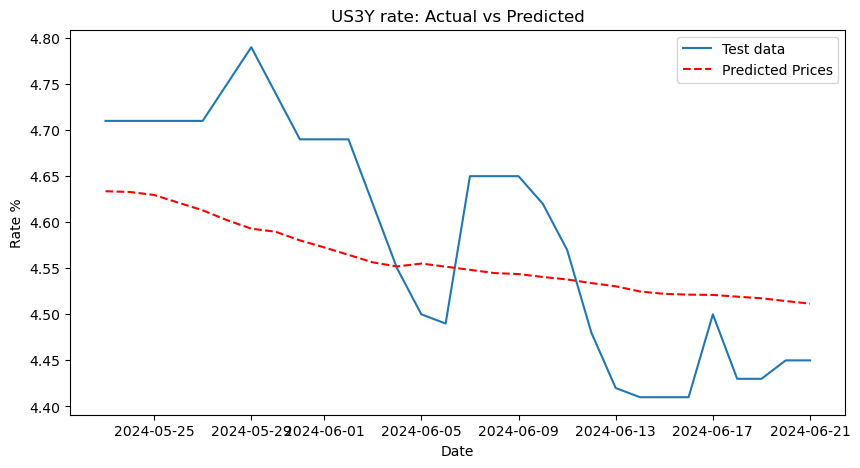

RMSE:  0.09807
CPU times: total: 22 s
Wall time: 12.6 s


In [37]:
%%time
from statsmodels.tsa.arima.model import ARIMA

# Fit the Moving Average (MA) model to the training data
model = ARIMA(train_diff, order=(31, 1, 0))
model_fit = model.fit()

# Make predictions on the test data
pred_diff = model_fit.predict(
    start = len(train_diff),
    end = len(train_diff) + len(test_diff) - 1,
    dynamic = False)

# revert prediction to actual values
test_original = pred_diff.cumsum() + filtered_data['US3Y'][-31]
# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test_diff.index, test_previous, label='Test data')
plt.plot(test_diff.index, test_original, color = 'red', linestyle = '--', label = 'Predicted Prices')
plt.title('US3Y rate: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Rate %')
plt.legend()
plt.show()

# evaluating model using RMSE score
rmse = round(np.sqrt(mean_squared_error(test_previous, test_original)), 5)
print('RMSE: ', rmse)

# Time series prediction on residuals
## Workflow
1. Fit a primary model to capture trend and seasonality (e.g., ARIMA, Prophet, STL decomposition).
2. Extract residuals:
   Residuals=Actual Values−Model Predictions
3. Check residual stationarity using ADF or KPSS test.
4. Fit a secondary model on residuals (e.g., AR, ARIMA, or ML models like XGBoost or LSTM if patterns exist).
5. Forecast residuals for the desired horizon.
6. Combine predictions:
   Final Forecast=Primary Model Forecast+Residual Forecast

### Step 1: Fit initial ARIMA model

In [42]:
%%time
# fit the training data into ARIMA model
model_1 = ARIMA(train_diff, order=(31, 1, 0))
fit_1 = model_1.fit()

# predict training_diff
pred_tr_diff_1 = fit_1.predict(start=0, end=len(train_diff)-1)

CPU times: total: 20.8 s
Wall time: 12.2 s


### Step 2: Get residuals

In [43]:
# transform the differencing training data back to its original scale [2004-01-01 - 2024-05-22]
pred_original_1 = pd.concat ([filtered_data['US3Y'].head(1), 
                              pred_tr_diff_1.cumsum() + filtered_data['US3Y'][0]])

residuals = filtered_data['US3Y'][:-30] - pred_original_1
residuals.head()

date
2000-01-01    0.000000
2000-01-02    0.000000
2000-01-03    0.130000
2000-01-04   -0.015062
2000-01-05    0.058858
Freq: D, dtype: float64

### Step 3: Check stationarity of residuals

In [44]:
check_stationarity(residuals)

ADF Statistic: -14.668093
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


In [28]:
# first order difference
res_diff = residuals.diff()
check_stationarity(res_diff.dropna())

ADF Statistic: -23.813601
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


### Step 4: Fit AR model on residuals (if p-value < 0.05, residuals are stationary)

In [29]:
stationary_residuals = res_diff.dropna().to_frame()
stationary_residuals.head()

,0
date,
2000-01-02,0.000188
2000-01-03,0.130192
2000-01-04,-0.077088
2000-01-05,0.091417
2000-01-06,-0.040384


#### ACF and PACF Plot of Residuals

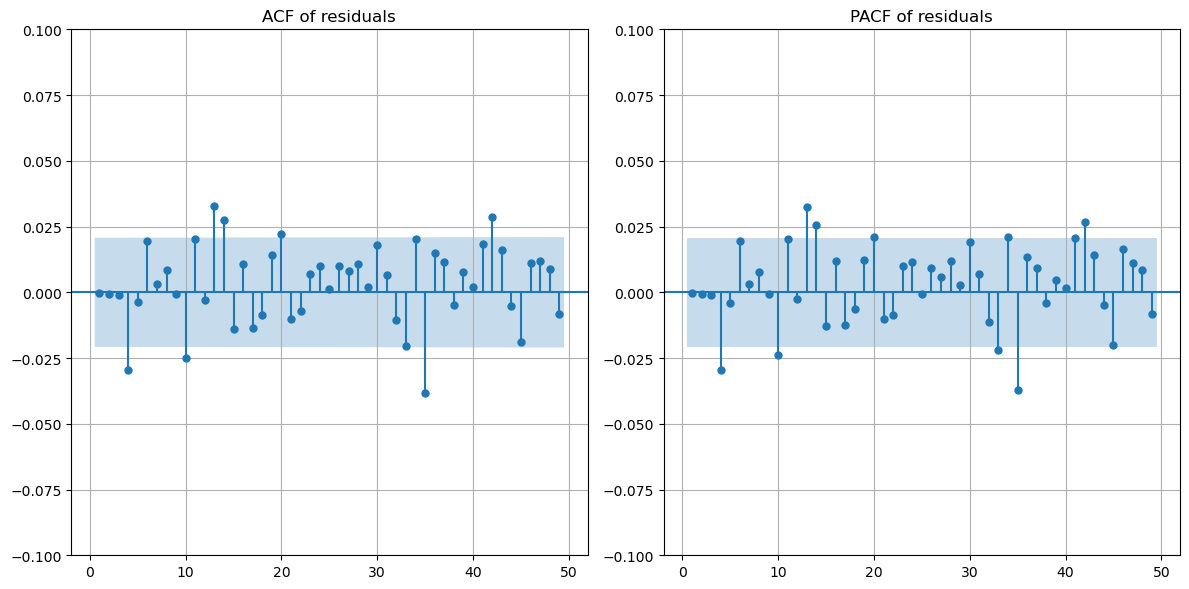

In [30]:
plt.figure(figsize = (12, 6))
# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(stationary_residuals, ax=plt.gca(), lags = range(1, 50))
plt.ylim(-0.1, 0.1)
plt.title('ACF of residuals')
plt.grid(True)
# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(stationary_residuals, ax=plt.gca(), lags = range(1, 50), method = 'ywm')
plt.ylim(-0.1, 0.1)
plt.title('PACF of residuals')
plt.grid(True)
plt.tight_layout()

plt.show()

In [31]:
%%time
# Fit Auto ARIMA model
model = auto_arima(
    stationary_residuals,       # target time series
    start_p = 1, 
    max_p = 50, 
    start_q = 1, 
    max_q = 50,
    seasonal=False,      # set True if data is seasonal
    stepwise=True,       # use stepwise search (faster)
    suppress_warnings=True,
    trace=True,           # print model fitting progress
    n_jobs = -1
)
# Summary of the model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22598.591, Time=0.82 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-25158.729, Time=0.92 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22600.591, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-26203.337, Time=2.95 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-26678.019, Time=1.52 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-27065.462, Time=1.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-27392.987, Time=1.02 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-27584.169, Time=1.63 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=-27737.744, Time=2.23 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=-27841.926, Time=10.78 sec
 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=-27893.684, Time=4.66 sec
 ARIMA(10,1,0)(0,0,0)[0] intercept   : AIC=-28005.308, Time=2.28 sec
 ARIMA(11,1,0)(0,

### Residual AR model

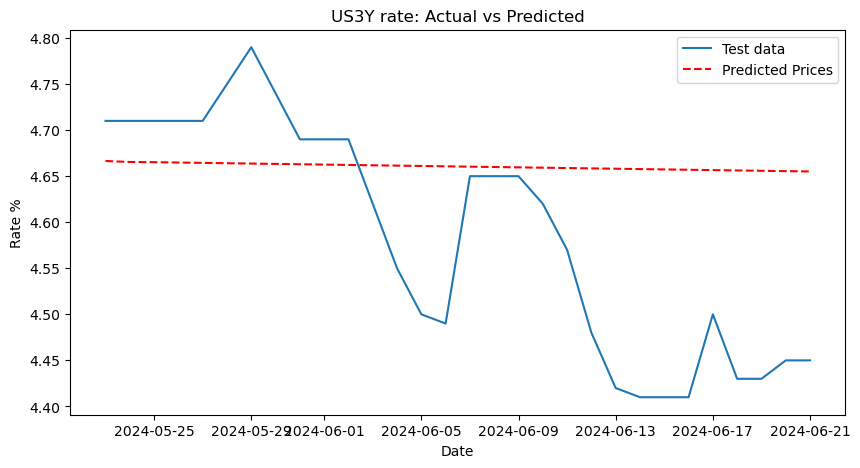

RMSE:  0.14183


In [32]:
# Fit the Autoregressive model (AR) to the training data
# Fit the Autoregressive model (AR) to the training data
model = AutoReg(train_diff, lags = 0)
model_fit_res = model.fit()

# Make predictions on residue
pred_res_diff = model_fit_res.forecast(steps=30)

# revert prediction to actual values
test_res_original = pred_res_diff.cumsum() + residuals[-1]

# make predictions on main data
forecast_main = fit_1.forecast(steps = 30, dynamic=False)
# revert prediction to actual values
test_original = forecast_main.cumsum() + filtered_data['US3Y'][-31]

final_forecast = test_original + test_res_original


# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(final_forecast.index, test_previous, label='Test data')
plt.plot(final_forecast.index, final_forecast, color = 'red', linestyle = '--', label = 'Predicted Prices')
plt.title('US3Y rate: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Rate %')
plt.legend()
plt.show()

# evaluating model using RMSE score
rmse = round(np.sqrt(mean_squared_error(test_previous, final_forecast)), 5)
print('RMSE: ', rmse)

### Main + Residual ARIMA Model

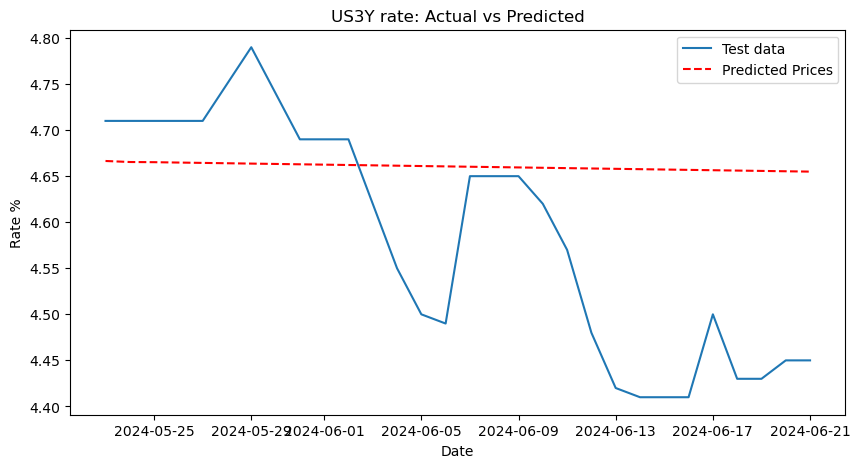

RMSE:  0.14176


In [33]:
# Fit the Autoregressive model (AR) to the training data
model_res = ARIMA(train_diff, order=(0, 0, 0))
model_fit_res = model_res.fit()

# Make predictions on residue
pred_res_diff = model_fit_res.forecast(steps=30, dynamic=False)

# revert prediction to actual values
test_res_original = pred_res_diff.cumsum() + residuals[-1]

# make predictions on main data
forecast_main = fit_1.forecast(steps = 30, dynamic=False)
# revert prediction to actual values
test_original = forecast_main.cumsum() + filtered_data['US3Y'][-31]

final_forecast = test_original + test_res_original


# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(final_forecast.index, test_previous, label='Test data')
plt.plot(final_forecast.index, final_forecast, color = 'red', linestyle = '--', label = 'Predicted Prices')
plt.title('US3Y rate: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Rate %')
plt.legend()
plt.show()

# evaluating model using RMSE score
rmse = round(np.sqrt(mean_squared_error(test_previous, final_forecast)), 5)
print('RMSE: ', rmse)